<a href="https://colab.research.google.com/github/Hassan56386/Hassan56386/blob/main/AI_HealthTech_for_Chemical_Exposure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install (usually preinstalled in Colab, but kept here for reproducibility)
!pip -q install seaborn

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Plot settings
sns.set(style="whitegrid", context="notebook", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8, 5)

print("Environment ready.")


Environment ready.


In [ ]:
# Safety thresholds (illustrative; adjust to your target environment and standards)
THRESHOLDS = {
    "CO2_ppm": {"low": 400, "moderate": 1000, "high": 2000},   # example bands
    "VOC_ppb": {"low": 100, "moderate": 300, "high": 600},
    "Temp_C":  {"min": 18, "max": 30},                         # comfort/safety band
    "Humidity_pct": {"min": 30, "max": 70}
}

def label_risk(row):
    """
    Simple rule-based risk:
    - Start with 'Safe'
    - Escalate to 'Caution' if any moderate exceedance
    - Escalate to 'High Risk' if any high exceedance or multiple moderate exceedances
    """
    score = 0

    # CO2 bands
    if row["CO2_ppm"] >= THRESHOLDS["CO2_ppm"]["high"]:
        score += 2
    elif row["CO2_ppm"] >= THRESHOLDS["CO2_ppm"]["moderate"]:
        score += 1

    # VOC bands
    if row["VOC_ppb"] >= THRESHOLDS["VOC_ppb"]["high"]:
        score += 2
    elif row["VOC_ppb"] >= THRESHOLDS["VOC_ppb"]["moderate"]:
        score += 1

    # Temperature outside band
    if (row["Temp_C"] < THRESHOLDS["Temp_C"]["min"]) or (row["Temp_C"] > THRESHOLDS["Temp_C"]["max"]):
        score += 1

    # Humidity outside band
    if (row["Humidity_pct"] < THRESHOLDS["Humidity_pct"]["min"]) or (row["Humidity_pct"] > THRESHOLDS["Humidity_pct"]["max"]):
        score += 1

    if score >= 3:
        return "High Risk"
    elif score >= 1:
        return "Caution"
    else:
        return "Safe"


In [ ]:
np.random.seed(42)
N = 6000  # number of samples (increase if you want)

# Base distributions (normal around typical indoor values)
CO2_base = np.random.normal(loc=800, scale=250, size=N).clip(350, 4000)
VOC_base = np.random.normal(loc=200, scale=120, size=N).clip(20, 2000)
Temp_base = np.random.normal(loc=24, scale=4, size=N).clip(10, 40)
Hum_base  = np.random.normal(loc=45, scale=12, size=N).clip(10, 90)

# Introduce correlations: higher CO2 often correlates with poor ventilation -> higher VOCs/humidity
VOC = VOC_base + 0.15 * (CO2_base - 800) + np.random.normal(0, 30, N)
VOC = VOC.clip(10, 3000)

Humidity = Hum_base + 0.05 * (CO2_base - 800) + np.random.normal(0, 5, N)
Humidity = Humidity.clip(10, 95)

Temp = Temp_base + 0.02 * (CO2_base - 800) + np.random.normal(0, 1.2, N)
Temp = Temp.clip(10, 45)

# Optional: airflow proxy (higher airflow reduces CO2/VOCs slightly)
Airflow = np.random.normal(loc=1.0, scale=0.3, size=N).clip(0.1, 2.0)
CO2 = CO2_base - 60 * (Airflow - 1.0)
VOC = VOC - 40 * (Airflow - 1.0)

# Build DataFrame
df = pd.DataFrame({
    "CO2_ppm": CO2.round(1),
    "VOC_ppb": VOC.round(1),
    "Temp_C": Temp.round(2),
    "Humidity_pct": Humidity.round(1),
    "Airflow_mps": Airflow.round(2),
})

# Label risk using the rule-based function
df["Risk"] = df.apply(label_risk, axis=1)

df.head()


,CO2_ppm,VOC_ppb,Temp_C,Humidity_pct,Airflow_mps,Risk
0,932.5,70.3,31.86,45.2,0.86,Caution
1,749.8,87.3,15.60,28.6,1.26,Caution
2,966.4,157.0,26.41,58.5,0.93,Safe
3,1180.3,247.0,31.87,57.7,1.01,Caution
4,742.9,138.6,22.28,56.2,0.98,Safe


Dataset shape: (6000, 6)

Risk class distribution:
 Risk
Caution      3384
Safe         2094
High Risk     522
Name: count, dtype: int64


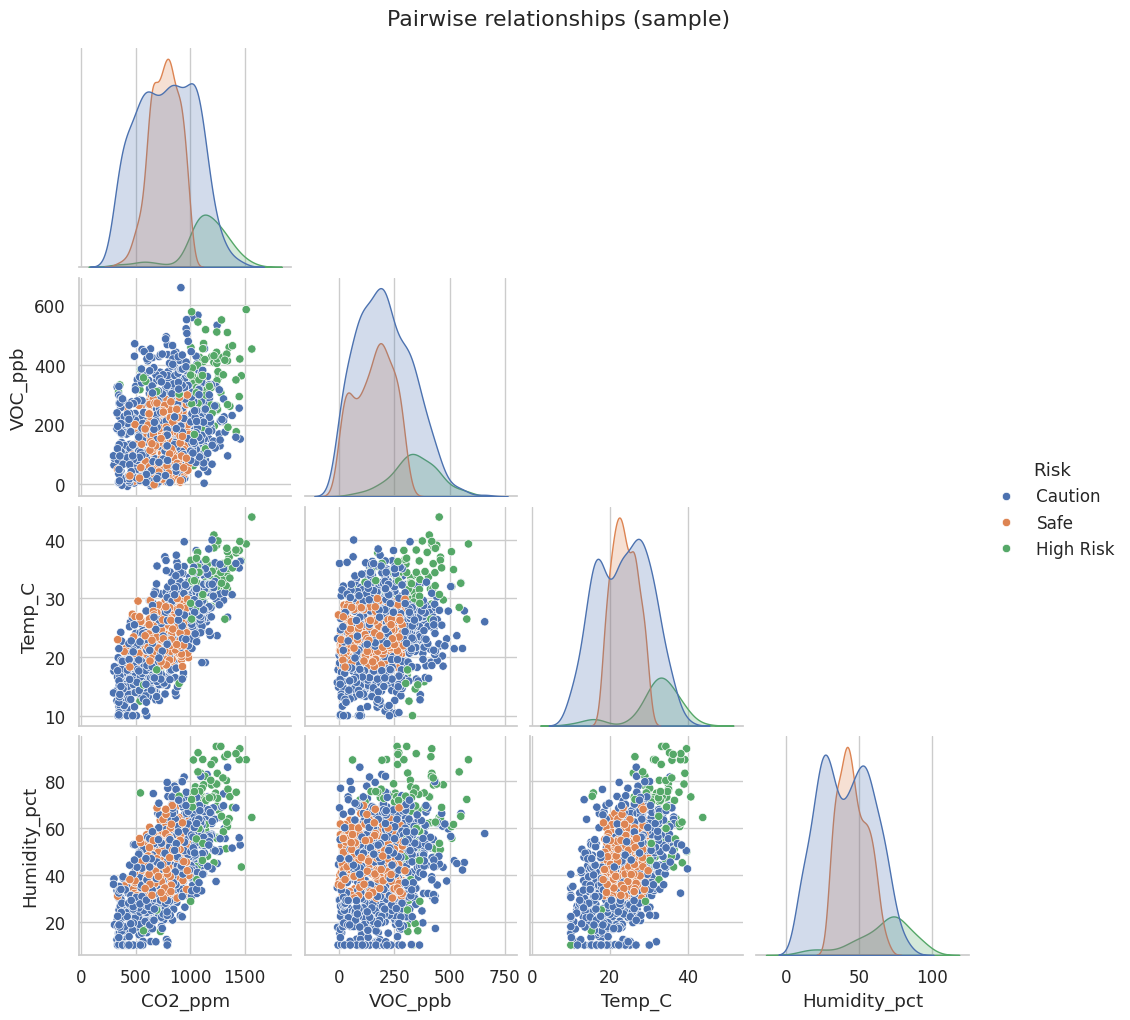

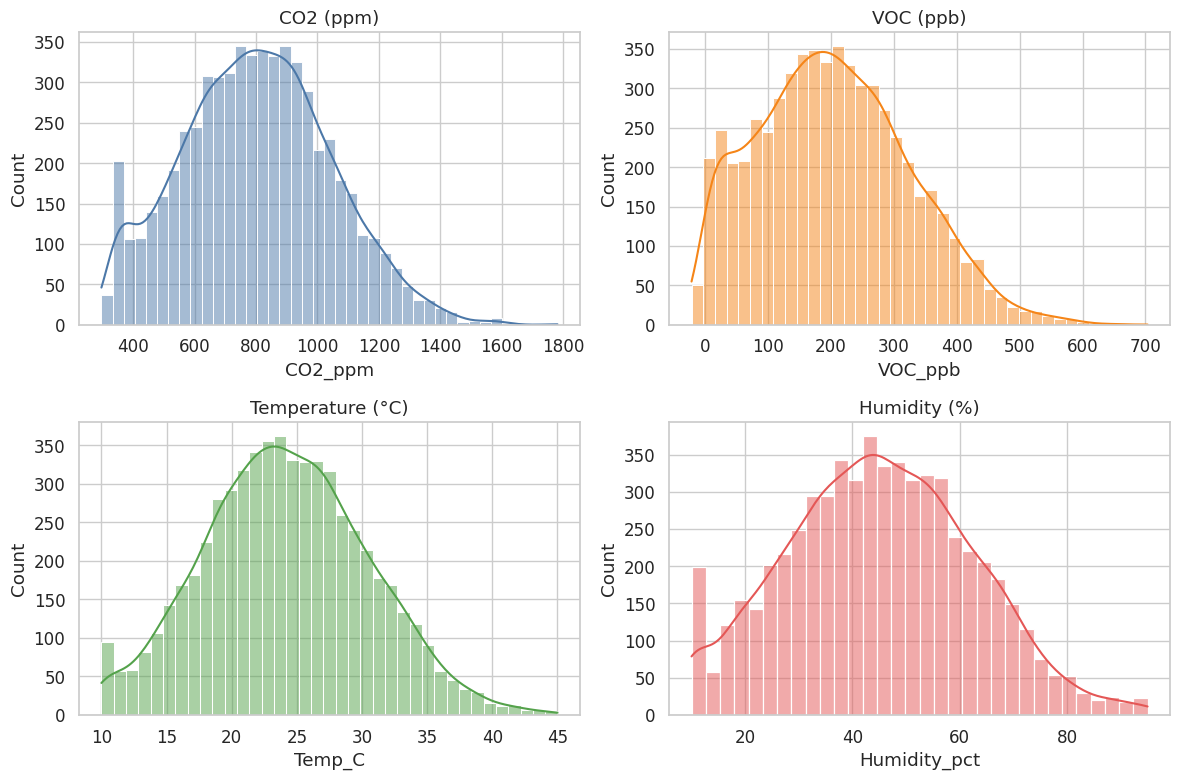

In [ ]:
print("Dataset shape:", df.shape)
print("\nRisk class distribution:\n", df["Risk"].value_counts())

# Pairplot (subset for speed)
sample = df.sample(1000, random_state=42)
sns.pairplot(sample, vars=["CO2_ppm", "VOC_ppb", "Temp_C", "Humidity_pct"], hue="Risk", corner=True)
plt.suptitle("Pairwise relationships (sample)", y=1.02)
plt.show()

# Histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df["CO2_ppm"], kde=True, ax=axs[0,0], color="#4c78a8")
axs[0,0].set_title("CO2 (ppm)")
sns.histplot(df["VOC_ppb"], kde=True, ax=axs[0,1], color="#f58518")
axs[0,1].set_title("VOC (ppb)")
sns.histplot(df["Temp_C"], kde=True, ax=axs[1,0], color="#54a24b")
axs[1,0].set_title("Temperature (°C)")
sns.histplot(df["Humidity_pct"], kde=True, ax=axs[1,1], color="#e45756")
axs[1,1].set_title("Humidity (%)")
plt.tight_layout()
plt.show()


In [ ]:
features = ["CO2_ppm", "VOC_ppb", "Temp_C", "Humidity_pct", "Airflow_mps"]
X = df[features].values
y = df["Risk"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (4500, 5) Test size: (1500, 5)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Feature scaling complete.")


Feature scaling complete.


In [ ]:
rf = RandomForestClassifier(
    n_estimators=250,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)

print("Model trained.")


Model trained.


Accuracy: 0.996

Classification Report:
               precision    recall  f1-score   support

     Caution       0.99      1.00      1.00       846
   High Risk       1.00      0.97      0.98       131
        Safe       1.00      1.00      1.00       523

    accuracy                           1.00      1500
   macro avg       1.00      0.99      0.99      1500
weighted avg       1.00      1.00      1.00      1500



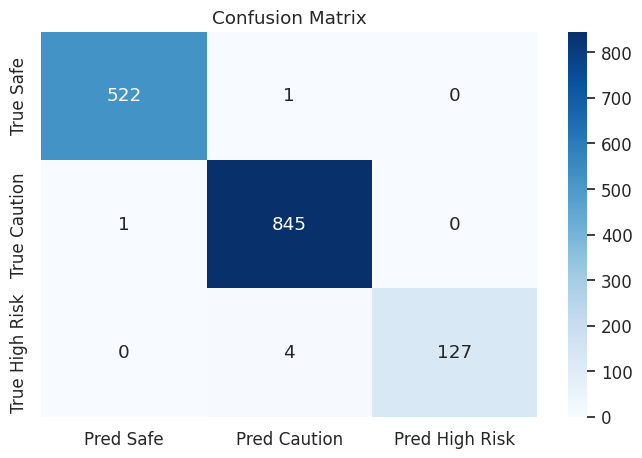

In [ ]:
y_pred = rf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=["Safe", "Caution", "High Risk"])
cm_df = pd.DataFrame(cm, index=["True Safe", "True Caution", "True High Risk"],
                        columns=["Pred Safe", "Pred Caution", "Pred High Risk"])

sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


/tmp/ipython-input-3142950056.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi, x="importance", y="feature", palette="viridis")


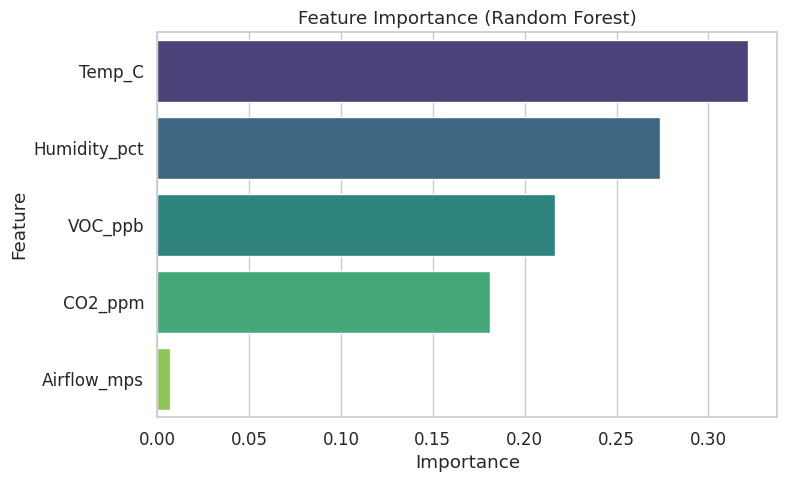

,feature,importance
2,Temp_C,0.321509
3,Humidity_pct,0.273747
1,VOC_ppb,0.216752
0,CO2_ppm,0.181382
4,Airflow_mps,0.006609


In [ ]:
importances = rf.feature_importances_
fi = pd.DataFrame({"feature": features, "importance": importances}).sort_values("importance", ascending=False)

sns.barplot(data=fi, x="importance", y="feature", palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

fi


/tmp/ipython-input-1811982819.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_by_bin = df.groupby("CO2_bin")["Risk"].value_counts(normalize=True).rename("proportion").reset_index()


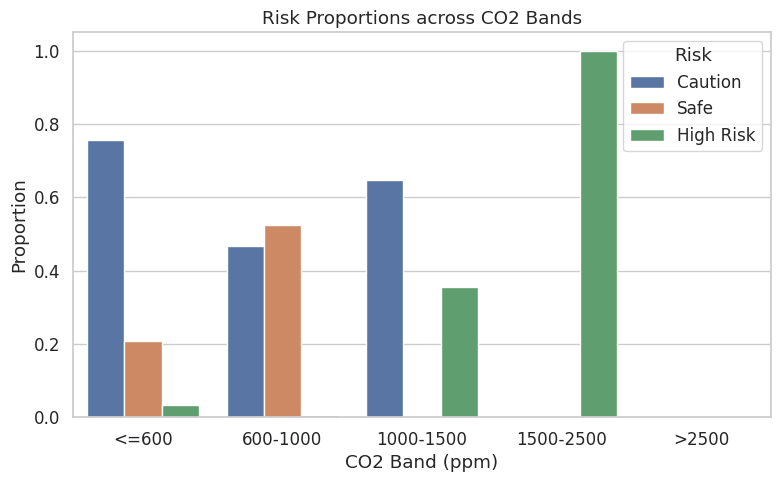

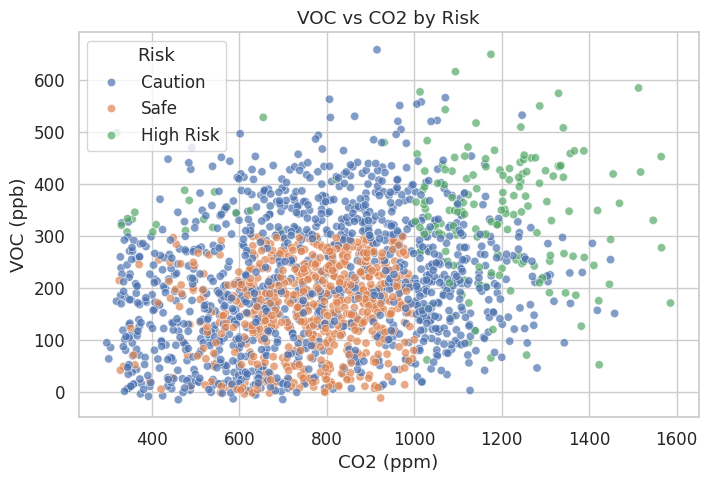

In [ ]:
# Bin CO2 and show risk proportions per bin
df["CO2_bin"] = pd.cut(df["CO2_ppm"], bins=[0, 600, 1000, 1500, 2500, 5000],
                       labels=["<=600", "600-1000", "1000-1500", "1500-2500", ">2500"])

risk_by_bin = df.groupby("CO2_bin")["Risk"].value_counts(normalize=True).rename("proportion").reset_index()

plt.figure(figsize=(9,5))
sns.barplot(data=risk_by_bin, x="CO2_bin", y="proportion", hue="Risk")
plt.title("Risk Proportions across CO2 Bands")
plt.ylabel("Proportion")
plt.xlabel("CO2 Band (ppm)")
plt.legend(title="Risk")
plt.show()

# Scatter: VOC vs CO2 colored by risk
plt.figure(figsize=(8,5))
sns.scatterplot(data=df.sample(2000, random_state=42), x="CO2_ppm", y="VOC_ppb", hue="Risk", alpha=0.7)
plt.title("VOC vs CO2 by Risk")
plt.xlabel("CO2 (ppm)")
plt.ylabel("VOC (ppb)")
plt.show()


In [ ]:
!pip -q install ipywidgets
import ipywidgets as widgets
from IPython.display import display

def predict_risk_interactive(co2, voc, temp, hum, airflow):
    x = np.array([[co2, voc, temp, hum, airflow]])
    x_scaled = scaler.transform(x)
    pred = rf.predict(x_scaled)[0]
    proba = rf.predict_proba(x_scaled)[0]
    proba_map = dict(zip(rf.classes_, proba))
    return pred, proba_map

co2_slider = widgets.FloatSlider(value=800, min=350, max=4000, step=10, description='CO2 (ppm)')
voc_slider = widgets.FloatSlider(value=200, min=10, max=3000, step=10, description='VOC (ppb)')
temp_slider = widgets.FloatSlider(value=24, min=10, max=45, step=0.5, description='Temp (°C)')
hum_slider  = widgets.FloatSlider(value=45, min=10, max=95, step=1, description='Humidity (%)')
air_slider  = widgets.FloatSlider(value=1.0, min=0.1, max=2.0, step=0.05, description='Airflow (m/s)')

out = widgets.Output()

def on_change(change):
    with out:
        out.clear_output()
        pred, proba = predict_risk_interactive(
            co2_slider.value, voc_slider.value, temp_slider.value, hum_slider.value, air_slider.value
        )
        print(f"Predicted Risk: {pred}")
        print("Class probabilities:")
        for k, v in proba.items():
            print(f"  {k}: {v:.2f}")

for w in [co2_slider, voc_slider, temp_slider, hum_slider, air_slider]:
    w.observe(on_change, names='value')

display(co2_slider, voc_slider, temp_slider, hum_slider, air_slider, out)
on_change(None)  # initial display


FloatSlider(value=800.0, description='CO2 (ppm)', max=4000.0, min=350.0, step=10.0)

FloatSlider(value=200.0, description='VOC (ppb)', max=3000.0, min=10.0, step=10.0)

FloatSlider(value=24.0, description='Temp (°C)', max=45.0, min=10.0, step=0.5)

FloatSlider(value=45.0, description='Humidity (%)', max=95.0, min=10.0, step=1.0)

FloatSlider(value=1.0, description='Airflow (m/s)', max=2.0, min=0.1, step=0.05)

Output()

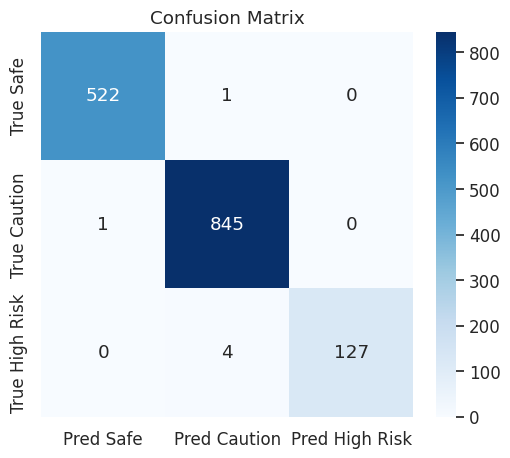

Artifacts saved: chemical_exposure_synthetic_dataset.csv, feature_importance.csv, confusion_matrix.png


In [ ]:
# Save dataset and feature importance
df.to_csv("chemical_exposure_synthetic_dataset.csv", index=False)
fi.to_csv("feature_importance.csv", index=False)

# Save a couple of figures programmatically (re-run plots to save if needed)
# Example: save confusion matrix directly
cm = confusion_matrix(y_test, y_pred, labels=["Safe", "Caution", "High Risk"])
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=["Pred Safe", "Pred Caution", "Pred High Risk"],
            yticklabels=["True Safe", "True Caution", "True High Risk"])
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png", bbox_inches="tight")
plt.show()

print("Artifacts saved: chemical_exposure_synthetic_dataset.csv, feature_importance.csv, confusion_matrix.png")


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring="accuracy", n_jobs=-1)
print(f"Cross-validated accuracy: mean={scores.mean():.3f}, std={scores.std():.3f}")


Cross-validated accuracy: mean=0.994, std=0.004
